CODE BY: Amitrajit Bose

CODE FROM: https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

COMMENTS BY: KUBA Jerzmanowski

In [1]:
#jsut block of code with imports
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

In [2]:
#this line is a pre processing step for the data. We turn the data into tensors and then normalize the inputs.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),]) 

#these lines just import the data as torch Dataset
trainset = datasets.MNIST('/Users/kuba/Documents/Data/Datasets', download=True, train=True, transform=transform)
valset = datasets.MNIST('/Users/kuba/Documents/Data/Datasets', download=True, train=False, transform=transform)

# These lines create the "dataloader" which is just an iterator wrapped around the Dataset.
# This is necessary if you want to train with batches as we are doing
# Note: training with batches incurs other benefits (possibly better convergence) that are not just
# because we can't fit the whole dataset into memory at once
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [3]:
#here the aouther of the code made of variable but to make def the model easyer later
#but these coudl have also been hardcoded
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Here we define the structure of our model. It's a Feedforward network.
# We use the values from before, but the structure of our network is an MLP with 2 hidden layers.
# We use ReLU nonlinearity and softmax on the output layer to turn the logits into prediction probabilities.
# (Not fully true we use log softmax since its more numerically safe but you can apply e^y to get the true prediction values)
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

In [4]:
# we define the loss metric we are using with will ne negative log-likelihood 
criterion = nn.NLLLoss()

#our optimizer is Adam 
optimizer = optim.Adam(model.parameters())

#def the num epochs to train for
epochs = 15
for epoch in range(epochs):
    running_loss = 0
    #sample batch from dataloader
    for images, labels in trainloader:
        # flatten it from 28x28 to 784 
        images = images.view(images.shape[0], -1)
    
        #clear the gradient (if we dont last one will be stored messing up our optimization step)
        optimizer.zero_grad()
        
        #forward pass of the model
        output = model(images)

        #use our defined loss metric to compute loss on this batches forward pass
        loss = criterion(output, labels)
        
        #they use auto diff (but thik the chain rule and we calc the gradient)
        loss.backward()
        
        #given our gradinet how do we step?
        #thats defined by our optimizer and it takes the step here updating the weights
        optimizer.step()
        
        # We just save the loss value so we can display the total loss later or per-epoch loss, etc.
        running_loss += loss.item()
        

In [5]:
# We again have some var to keep track of how we are doing 
correct_count, all_count = 0, 0
y_pred = []
y_true = []

# This bit here is the evaluation loop.
# We pass in the examples from the valloader, which were never seen during training, and see how we perform.
# Note that here the weights are constant and are not changing. There is no more learning here, just evaluation.
# I would like to note that this could have been implemented with a single forward pass in parallel for each batch
# rather than iterating over each example in the batch individually. However, this is how the original code was written.
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    y_pred.append(pred_label)
    y_true.append(true_label)
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9744


In [6]:
print("\nModel F1 score =", f1_score(y_true=y_true,y_pred=y_pred,average='macro'))


Model F1 score = 0.9742623742463945


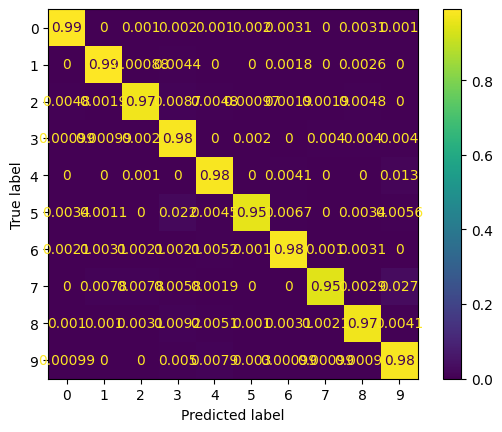

In [7]:
ConfusionMatrixDisplay.from_predictions(y_true,y_pred, normalize='true')
plt.show()